# EIA Project

Following a summary of the project. For more details, go to the report

**About the EIA**

The U.S. Energy Information Administration (EIA) is a government agency within the U.S. Department of Energy that collects, analyzes, and publishes independent and impartial energy information.
Its mission is to promote sound policymaking, efficient markets, and public understanding of energy and its interaction with the economy and the environment.

The EIA provides comprehensive data on petroleum, natural gas, coal, electricity, renewables, and nuclear energy with production, consumption, imports/exports, inventories, prices, regular reports such as the Weekly Petroleum Status Report (WPSR), Short-Term Energy Outlook, and Annual Energy Outlook.

For oil markets, the Weekly Petroleum Status Report is a key source of market fundamentals, summarizing U.S. crude oil and petroleum product supply, demand, and inventory levels — data closely followed by traders, analysts, and policy makers for its potential to influence market sentiment and decision-making.

Source: https://www.eia.gov/

**Business Problem**

An energy trading desk wants to understand which petroleum market fundamentals have the most influence on WTI spot prices, so they can prioritize monitoring and risk assessments on the most impactful indicators.

By identifying and quantifying these relationships, the desk can improve market awareness, refine hedging strategies, and enhance the efficiency of internal reporting.

**Business Question**

Which petroleum market fundamentals reported in the EIA’s Weekly Petroleum Status Report have the strongest historical influence on weekly average WTI spot prices?

**Stakeholders**

-	Trading desk: to allocate research resources toward the most relevant fundamentals.
- Market analysts: to focus daily commentary on key drivers.
- Risk management team: to incorporate key fundamentals into stress tests and VaR scenarios.
- Executives: to understand high-level market dynamics without deep technical knowledge.


**Business Objectives**

1.	Build a machine learning model to explain weekly average WTI spot price using petroleum market fundamentals from the EIA’s Weekly Petroleum Status Report (WPSR).
2.	Rank the importance of each feature in explaining historical price variation.
3.	Deliver actionable recommendations on which fundamentals to track most closely for market monitoring.


**Metrics**

Technical:
-	R² and MAE for in-sample model fit (to confirm model quality).
-	Feature importance rankings and interpretability metrics.

Business:

-	Clarity of insights for non-technical stakeholders.
-	Ability to produce a prioritized driver list that matches market intuition.


**Type of Modeling**

•	Regression (supervised learning) with emphasis on explanatory power.

•	Potential algorithms: Linear Regression, Lasso/Ridge, Random Forest Regressor, XGBoost Regressor.

•	Focus on interpretability alongside model fit quality (R², MAE).

**Dataset**

Source: U.S. Energy Information Administration (EIA) — Weekly Petroleum Status Report (WPSR) and related datasets.

Frequency: Weekly.

Period: ~30 years (if available) for robust statistical learning.

Target variable: EIA Weekly Average WTI spot price (Cushing, OK).

Features:

-	U.S. crude oil stocks (ex-SPR)
-	Total motor gasoline stocks
-	Distillate fuel oil stocks
-	Total product supplied
-	Refinery capacity utilization (%)
-	Crude oil production (U.S.)
-	Net imports/exports of crude and products
-	Seasonal indicator (week of year)

**Evaluation Plan**

1.	EDA to explore relationships between fundamentals and price.
2.	Model fitting with cross-validation for robustness.
3.	Feature importance analysis.
4.	Business interpretation — map statistical importance to actionable insights.

# Imports + Config

In [ ]:
from pathlib import Path
import pandas as pd
import re, textwrap, os
import json
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
BASE = Path('/content/drive/MyDrive/Colab Notebooks/EIA')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I will uses a master mapping file to get the right data

In [ ]:
# Load master mapping

mapping = pd.read_excel(BASE / "index_eia.xlsx")
mapping.columns = [c.strip().lower() for c in mapping.columns]
mapping = mapping.rename(columns={
    "variable":"variable",
    "code":"code",
    "file":"file",
    "sheet":"sheet",
    "frequency":"frequency",
    "units":"units"})[["variable","code","file","sheet","frequency","units"]]

mapping

,variable,code,file,sheet,frequency,units
0,us_product_supply,WRPUPUS2,products_supplied_kbd.xls,product_supply,weekly,kbd
1,us_crude_imports,WCRIMUS2,crude_imports_exports_kbd.xls,imports,weekly,kbd
2,us_pro_imports,WRPIMUS2,crude_imports_exports_kbd.xls,imports,weekly,kbd
3,us_crude_exports,WCREXUS2,crude_imports_exports_kbd.xls,exports,weekly,kbd
4,us_pro_exports,WRPEXUS2,crude_imports_exports_kbd.xls,exports,weekly,kbd
5,us_crude_net_imports,WCRNTUS2,crude_imports_exports_kbd.xls,net_imports,weekly,kbd
6,us_pro_net_imports,WRPNTUS2,crude_imports_exports_kbd.xls,net_imports,weekly,kbd
7,us_refinery_input_kbd,WCRRIUS2,refinery_util_input_kbd.xls,us_refinery_util_kbd,weekly,kbd
8,us_refinery_util_prct,WPULEUS3,refinery_util_input_kbd.xls,us_refinery_util_kbd,weekly,percent
9,PADD3_refinery_input_kbd,WCRRIP32,refinery_util_input_kbd.xls,PADD3_refinery_util_kbd,weekly,kbd


A dedicated extract_series helper function was implemented to encapsulate the recurring logic for reading EIA .xls files. This ensures consistent handling of the common layout (code in row 2, description in row 3, dates starting in row 4), avoids repetitive code, and centralizes any future adjustments to the extraction process in a single location. This approach improves maintainability, reduces errors, and keeps the main processing loop clear and concise.

In [ ]:
# Read single series using your sheet layout
def extract_series(xls_path: Path, sheet: str, code: str, variable: str) -> pd.DataFrame:
    df_raw = pd.read_excel(xls_path, sheet_name=sheet, header=None, engine="xlrd")

    # Find column whose row-2 (index 1) equals the code; try a small scan if not found
    header_row_idx = 1
    col_idx = None
    for r in [1, 0, 2, 3, 4]:  # robust if header row is slightly off
        row = df_raw.iloc[r].astype(str).str.strip()
        hit = row.eq(str(code).strip())
        if hit.any():
            col_idx = int(hit.idxmax())
            header_row_idx = r
            break
    if col_idx is None:
        raise ValueError(f"Code '{code}' not found in first 5 rows of {xls_path.name}/{sheet}")

    # Data starts on row 4 (index 3); dates in col A (index 0)
    data = df_raw.iloc[3:, [0, col_idx]].copy()
    data.columns = ["date", "value"]
    data["date"] = pd.to_datetime(data["date"], errors="coerce")
    data = data.dropna(subset=["date"]).reset_index(drop=True)
    data["variable"] = variable
    return data[["date", "variable", "value"]]

Some data is weekly, some is daily, some is monthly
I will treat them differnt and fis it in the preprocessing phase

In [ ]:
# Build weekly / monthly / daily long tables
frames = {"weekly": [], "monthly": [], "daily": []}
errors = []

The main loop iterates over the master mapping file, reading metadata for each series (variable name, EIA code, file, sheet, and frequency) and passing it to the extract_series helper. The extracted data is organized by frequency (weekly, monthly, daily), while any issues encountered—such as missing files or unmatched codes—are logged for review. This design enables fully automated extraction of all series defined in the mapping without manual intervention.

In [ ]:
# Iterate through each row in mapping

for _, row in mapping.iterrows():

    # Extract the metadata for this series
    var  = str(row["variable"]).strip()     # Variable name (friendly label)
    code = str(row["code"]).strip()         # EIA series code (used to find the column in the sheet)
    file = str(row["file"]).strip()         # Excel file name
    sheet= str(row["sheet"]).strip()        # Sheet name in the Excel file
    freq = str(row["frequency"]).strip().lower()  # Frequency (weekly, monthly, daily)

    # Full path to the Excel file in Google Drive
    xls = BASE / file

    try:
        # Extract the time series from the file/sheet using the helper function
        out = extract_series(xls, sheet, code, var)

        # Append the extracted series to the appropriate frequency list
        if freq in frames:
            frames[freq].append(out)
        else:
            errors.append(f"[UNKNOWN FREQ] {freq} for {var}")

    except Exception as e:
        # Log any errors for later review (e.g., missing file, code not found)
        errors.append(f"[READ ERROR] {var} ({code}) from {file}/{sheet}: {e}")

In [ ]:
# Ceate 3 dataframe
weekly_df  = pd.concat(frames["weekly"],  ignore_index=True) if frames["weekly"]  else pd.DataFrame(columns=["date","variable","value"])
monthly_df = pd.concat(frames["monthly"], ignore_index=True) if frames["monthly"] else pd.DataFrame(columns=["date","variable","value"])
daily_df   = pd.concat(frames["daily"],   ignore_index=True) if frames["daily"]   else pd.DataFrame(columns=["date","variable","value"])

In [ ]:
print("\nCounts:")
print("Weekly rows:", len(weekly_df))
print("Monthly rows:", len(monthly_df))
print("Daily rows:", len(daily_df))


Counts:
Weekly rows: 30591
Monthly rows: 1265
Daily rows: 19662


In [ ]:
# Check the first few rows of each frequency DataFrame
print("\nWeekly series sample:")
print(weekly_df.tail())

print("\nMonthly series sample:")
print(monthly_df.tail())

print("\nDaily series sample:")
print(daily_df.tail())


Weekly series sample:
            date          variable   value
30586 2025-07-04  PADD3_stock_kbbl  240749
30587 2025-07-11  PADD3_stock_kbbl  238774
30588 2025-07-18  PADD3_stock_kbbl  237802
30589 2025-07-25  PADD3_stock_kbbl  243850
30590 2025-08-01  PADD3_stock_kbbl  242232

Monthly series sample:
           date                    variable  value
1260 2025-01-15  us_crude_field_product_kbd  13141
1261 2025-02-15  us_crude_field_product_kbd  13240
1262 2025-03-15  us_crude_field_product_kbd  13453
1263 2025-04-15  us_crude_field_product_kbd  13464
1264 2025-05-15  us_crude_field_product_kbd  13488

Daily series sample:
            date            variable  value
19657 2025-07-29  brent_spot_usd_bbl  73.21
19658 2025-07-30  brent_spot_usd_bbl  73.98
19659 2025-07-31  brent_spot_usd_bbl  73.43
19660 2025-08-01  brent_spot_usd_bbl  70.55
19661 2025-08-04  brent_spot_usd_bbl  69.56


In [ ]:
# Check the last few rows of each frequency DataFrame
print("\nWeekly series sample:")
print(weekly_df.head())

print("\nMonthly series sample:")
print(monthly_df.head())

print("\nDaily series sample:")
print(daily_df.head())


Weekly series sample:
        date           variable  value
0 1990-11-09  us_product_supply  16588
1 1990-11-16  us_product_supply  17019
2 1990-11-23  us_product_supply  15686
3 1990-11-30  us_product_supply  17753
4 1990-12-07  us_product_supply  16901

Monthly series sample:
        date                    variable value
0 1920-01-15  us_crude_field_product_kbd  1097
1 1920-02-15  us_crude_field_product_kbd  1145
2 1920-03-15  us_crude_field_product_kbd  1167
3 1920-04-15  us_crude_field_product_kbd  1165
4 1920-05-15  us_crude_field_product_kbd  1181

Daily series sample:
        date          variable  value
0 1986-01-02  wti_spot_usd_bbl  25.56
1 1986-01-03  wti_spot_usd_bbl     26
2 1986-01-06  wti_spot_usd_bbl  26.53
3 1986-01-07  wti_spot_usd_bbl  25.85
4 1986-01-08  wti_spot_usd_bbl  25.87


The to_wide() function converts raw long-format data ([date, variable, value]) into a wide-format table, where each variable is a separate column and dates are the index. Dates are optionally normalized to:

- W → week-ending Sundays (for weekly EIA data)

- M-start → month start

- M-end → month end

Duplicate (date, variable) entries are aggregated (default = last value). The result is pivoted, sorted by date, and columns reordered alphabetically. This process is applied separately to build weekly_wide, monthly_wide, and daily_wide datasets for later analysis.

In [ ]:
# --- Wide tables: one column per variable, indexed by date ---

def to_wide(df, normalize=None, agg="last"):
    """
    df: long table with columns [date, variable, value]
    normalize: None | "W" | "M-start" | "M-end"
    agg: how to combine duplicates per (date, variable) if any
    """
    out = df.copy()
    out["value"] = pd.to_numeric(out["value"], errors="coerce")

    # optional date normalization
    if normalize == "W":          # week-end dating
        out["date"] = out["date"].dt.to_period("W").dt.to_timestamp("W-SUN")
    elif normalize == "M-start":  # month-start dating
        out["date"] = out["date"].dt.to_period("M").dt.to_timestamp("MS")
    elif normalize == "M-end":    # month-end dating
        out["date"] = out["date"].dt.to_period("M").dt.to_timestamp("M")

    # guard against accidental duplicates
    if out.duplicated(subset=["date", "variable"]).any():
        out = out.groupby(["date", "variable"], as_index=False)["value"].agg(agg)

    wide = (out.pivot(index="date", columns="variable", values="value")
               .sort_index())
    wide = wide.reindex(sorted(wide.columns), axis=1)
    return wide

# Build wide tables
weekly_wide  = to_wide(weekly_df,  normalize="W")
monthly_wide = to_wide(monthly_df, normalize="M-end")
daily_wide   = to_wide(daily_df,   normalize=None)

# Peek (TAIL)
TAIL_N = 5
print("weekly_wide shape:", weekly_wide.shape)
print(weekly_wide.tail(TAIL_N), "\n")

print("monthly_wide shape:", monthly_wide.shape)
print(monthly_wide.tail(TAIL_N), "\n")

print("daily_wide shape:", daily_wide.shape)
print(daily_wide.tail(TAIL_N))

weekly_wide shape: (2236, 16)
variable    PADD2_refinery_input_kbd  PADD2_refinery_util_prct  \
date                                                             
2025-07-06                    4168.0                      98.3   
2025-07-13                    4079.0                      96.2   
2025-07-20                    4161.0                      97.8   
2025-07-27                    4133.0                      97.3   
2025-08-03                    4209.0                      99.1   

variable    PADD3_refinery_input_kbd  PADD3_refinery_util_prct  \
date                                                             
2025-07-06                    9228.0                      95.3   
2025-07-13                    9225.0                      94.8   
2025-07-20                    9196.0                      96.1   
2025-07-27                    9230.0                      96.5   
2025-08-03                    9250.0                      97.1   

variable    PADD3_stock_kbbl  cushing_stock_

In [ ]:
# Show all columns in weekly_wide
print(weekly_wide.columns.tolist())

# Or, more neatly with index and type
for i, col in enumerate(weekly_wide.columns):
    print(f"{i}: {col} ({weekly_wide[col].dtype})")

['PADD2_refinery_input_kbd', 'PADD2_refinery_util_prct', 'PADD3_refinery_input_kbd', 'PADD3_refinery_util_prct', 'PADD3_stock_kbbl', 'cushing_stock_kbbl', 'us_crude_exports', 'us_crude_imports', 'us_crude_net_imports', 'us_pro_exports', 'us_pro_imports', 'us_pro_net_imports', 'us_product_supply', 'us_refinery_input_kbd', 'us_refinery_util_prct', 'us_stock_kbbl']
0: PADD2_refinery_input_kbd (float64)
1: PADD2_refinery_util_prct (float64)
2: PADD3_refinery_input_kbd (float64)
3: PADD3_refinery_util_prct (float64)
4: PADD3_stock_kbbl (float64)
5: cushing_stock_kbbl (float64)
6: us_crude_exports (float64)
7: us_crude_imports (float64)
8: us_crude_net_imports (float64)
9: us_pro_exports (float64)
10: us_pro_imports (float64)
11: us_pro_net_imports (float64)
12: us_product_supply (float64)
13: us_refinery_input_kbd (float64)
14: us_refinery_util_prct (float64)
15: us_stock_kbbl (float64)


**Data Acquisition & Preparation - Summary**

We began by downloading all required historical EIA time series in .xls format, replacing the API pull due to service issues. A mapping file (index_eia.xlsx) was used to match each variable to its EIA series code, source file, sheet, frequency, and units, so we built a Python extraction function in Colab to read the correct sheet and column by locating the EIA series code in the header and extract and clean the date–value pairs for each variable.

Finally, we transformed the long tables into weekly, monthly, and daily wide-format tables (weekly_wide, monthly_wide, daily_wide) for analysis, ensuring consistent date alignment and handling missing values.

Initial attempts to pull data directly from the EIA API failed due to persistent HTTP 500 errors across multiple retry attempts (Whole Day1). These errors indicated server-side problems that prevented reliable data retrieval whcih was confirmed by the web site. As a result, I switched to downloading the official raw .xls files directly from the EIA website. This approach ensured complete data availability, eliminated connection instability, and allowed consistent processing using a custom Python extraction workflow.

# Exploratory Phase (EDA)

Some preliminary exploration was already completed during the data acquisition phase. In the next steps, we will expand the exploratory process by systematically evaluating the presence of missing values in the daily, weekly, and monthly datasets. This assessment will be performed before merging all series into a single, comprehensive DataFrame, ensuring that we understand and address data quality issues prior to full integration.

# Check missing values - Monthly Data

No missing values

In [ ]:
# Check missing values before unifying
monthly_wide.isna().sum()

,0
variable,
us_crude_field_product_kbd,0


# Converting monthly crude oil production into weekly

The U.S. crude oil production data from the EIA is reported in thousands of barrels per month. To align it with our weekly dataset, we first converted monthly totals into daily production volumes by dividing by the actual number of days in each month (accounting for varying month lengths and leap years).

We then aggregated these daily values into weekly totals ending on Sunday. This produces the total number of barrels produced each week, expressed in thousands of barrels, ensuring full comparability with other weekly supply, imports, and exports variables in our dataset.

In [ ]:
# Convert monthly production (kbbl/month) to daily production (kbbl/day)
daily_prod = (
    monthly_wide
    .resample("D")  # expand to daily frequency
    .ffill()        # fill forward the monthly value across days
)

# Divide by actual days in month to get daily production
daily_prod = daily_prod.div(daily_prod.index.days_in_month, axis=0)

# Aggregate into weekly totals ending on Sunday
weekly_prod_total = daily_prod.resample("W-SUN").sum().round()

weekly_prod_total.tail(10)

variable,us_crude_field_product_kbd
date,
2025-03-30,2990.0
2025-04-06,3125.0
2025-04-13,3139.0
2025-04-20,3139.0
2025-04-27,3139.0
2025-05-04,3083.0
2025-05-11,3040.0
2025-05-18,3040.0
2025-05-25,3040.0


Notice the last number for the 1st week of june is not correct because it's taking a 'cero' the field production in the month of June.

For that specific week I will replace with the last value which is an excellent aproximation

In [ ]:
weekly_prod_total.loc['2025-06-01', 'us_crude_field_product_kbd'] = weekly_prod_total.loc['2025-05-25', 'us_crude_field_product_kbd']
weekly_prod_total.tail(10)

variable,us_crude_field_product_kbd
date,
2025-03-30,2990.0
2025-04-06,3125.0
2025-04-13,3139.0
2025-04-20,3139.0
2025-04-27,3139.0
2025-05-04,3083.0
2025-05-11,3040.0
2025-05-18,3040.0
2025-05-25,3040.0


# Check missing values - Daily Data

In [ ]:
# Check missing values before unifying
daily_wide.isna().sum()

,0
variable,
brent_spot_usd_bbl,441
wti_spot_usd_bbl,169


The missing values in crude oil prices are primarily due to U.S. holidays (e.g., Independence Day, Thanksgiving), European/UK bank holidays (e.g., Boxing Day, Good Friday), and global holidays where both markets are closed (e.g., New Year’s Day, Christmas Day). In the oil market, the standard practice for handling such cases is to carry forward the last available price (i.e., repeat the previous day’s settlement), since no trading occurred and market conditions did not change. Forward-filling is preferred over interpolation because it preserves the integrity of the actual price history—interpolation would artificially create prices for days when no trading happened, potentially introducing misleading patterns into market trend analysis.

However, since our analysis uses **weekly averages**, we will keep daily gaps as missing; **Pandas naturally ignores NaNs when averaging**, so weekly means are computed from the available trading days without inserting artificial values.

# Coverting daily prices to weekly average

The daily Brent and WTI spot price series will be converted into weekly averages to match the frequency of the other market variables. Using a week-ending Sunday convention ensures perfect alignment with the EIA’s weekly petroleum data.

Again, during the resampling process, Pandas automatically ignores NaN values when computing the mean, which prevents non-trading days (e.g., market holidays) from biasing the weekly averages, maintaining data consistency while preserving the integrity of the actual trading history, avoiding artificial price generation for days when no trades occurred.

In [ ]:
weekly_prices = daily_wide.resample('W-SUN').mean()
weekly_prices.tail()

variable,brent_spot_usd_bbl,wti_spot_usd_bbl
date,,
2025-07-13,71.774,69.146
2025-07-20,70.656,68.074
2025-07-27,70.086,67.108
2025-08-03,72.408,69.584
2025-08-10,69.560,67.330


In [ ]:
weekly_prices.isna().sum()

,0
variable,
brent_spot_usd_bbl,72
wti_spot_usd_bbl,0


In [ ]:
weekly_prices.head()

variable,brent_spot_usd_bbl,wti_spot_usd_bbl
date,,
1986-01-05,NaN,25.780
1986-01-12,NaN,25.986
1986-01-19,NaN,24.568
1986-01-26,NaN,20.314
1986-02-02,NaN,19.692


The missing value in Brent are at the begining of the dataset, they will be cut off in the following steps

# Check missing values - Weekly Data

In [ ]:
# Check missing values before unifying
weekly_wide.isna().sum()

,0
variable,
PADD2_refinery_input_kbd,519
PADD2_refinery_util_prct,1444
PADD3_refinery_input_kbd,519
PADD3_refinery_util_prct,1444
PADD3_stock_kbbl,379
cushing_stock_kbbl,1123
us_crude_exports,436
us_crude_imports,379
us_crude_net_imports,997


Most of the missing value are older series that were not collected back in the days or EIA changed the methodology.

The next cleaning process will be cutting off the data serie


In [ ]:
weekly_wide.head()

variable,PADD2_refinery_input_kbd,PADD2_refinery_util_prct,PADD3_refinery_input_kbd,PADD3_refinery_util_prct,PADD3_stock_kbbl,cushing_stock_kbbl,us_crude_exports,us_crude_imports,us_crude_net_imports,us_pro_exports,us_pro_imports,us_pro_net_imports,us_product_supply,us_refinery_input_kbd,us_refinery_util_prct,us_stock_kbbl
date,,,,,,,,,,,,,,,,
1982-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11722.0,NaN,NaN
1982-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11918.0,NaN,NaN
1982-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12375.0,NaN,NaN
1982-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12303.0,NaN,NaN
1982-10-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12062.0,NaN,NaN


**Justification: Cutting off**

A 14-year period provides a robust and representative sample for capturing medium- to long-term market trends, offering enough observations for meaningful statistical analysis while avoiding excessive historical noise.

Older patterns—such as the severe landlock of WTI at Cushing in the 2000s, which no longer reflects current operational dynamics—could bias results if included. For higher data completeness, consistency across all variables, and market relevance. Also, most missing values were concentrated in the earliest years of the dataset, with significant gaps in PADD2 and PADD3 refinery utilization before June 2010.

For weekly data, 14 years gives you roughly 730+ observations, which is more than enough to detect seasonal cycles, structural changes, and long-term trends. Energy markets often go through multi-year cycles (e.g., supply shocks, price collapses, infrastructure expansions). Fourteen years usually covers several complete market cycles, making the analysis more robust.

The analysis was restricted to June 2010–August 2025. This cutoff minimizes data gaps, aligns all time series to a common coverage period, and ensures the dataset reflects modern market behavior.

In [ ]:
# Set cutoff
CUTOFF = pd.Timestamp("2010-06-01")

weekly_wide_cut  = weekly_wide.loc[weekly_wide.index  >= CUTOFF].copy()
monthly_wide_cut = daily_prod.loc[daily_prod.index >= CUTOFF].copy()
daily_wide_cut   = weekly_prices.loc[weekly_prices.index   >= CUTOFF].copy()

print("Shapes after cutoff (>= 2010-06-01):")
print("weekly_wide_cut :", weekly_wide_cut.shape)
print("monthly_wide_cut:", monthly_wide_cut.shape)
print("daily_wide_cut  :", daily_wide_cut.shape)

# Recheck missing values (counts)
for name, df in {
    "weekly_wide_cut": weekly_wide_cut,
    "monthly_wide_cut": monthly_wide_cut,
    "daily_wide_cut": daily_wide_cut
}.items():
    print(f"\n{name} — missing values:")
    print(df.isna().sum().sort_values(ascending=False))

Shapes after cutoff (>= 2010-06-01):
weekly_wide_cut : (792, 16)
monthly_wide_cut: (5479, 1)
daily_wide_cut  : (793, 2)

weekly_wide_cut — missing values:
variable
PADD2_refinery_input_kbd    0
PADD2_refinery_util_prct    0
PADD3_refinery_input_kbd    0
PADD3_refinery_util_prct    0
PADD3_stock_kbbl            0
cushing_stock_kbbl          0
us_crude_exports            0
us_crude_imports            0
us_crude_net_imports        0
us_pro_exports              0
us_pro_imports              0
us_pro_net_imports          0
us_product_supply           0
us_refinery_input_kbd       0
us_refinery_util_prct       0
us_stock_kbbl               0
dtype: int64

monthly_wide_cut — missing values:
variable
us_crude_field_product_kbd    0
dtype: int64

daily_wide_cut — missing values:
variable
brent_spot_usd_bbl    0
wti_spot_usd_bbl      0
dtype: int64


# Creating a new df with all the data

In [ ]:
weekly_all = (
    weekly_wide_cut
    .join(weekly_prices, how="left")
    .join(weekly_prod_total, how="left")
)

# Find latest date where ALL series have data (non-NaN)
common_end = weekly_all.dropna(how="any").index.max()

# Trim the merged DataFrame
weekly_all = weekly_all.loc[:common_end]

print("Final shape:", weekly_all.shape)
print("Last date in final dataset:", weekly_all.index.max())
print(weekly_all.tail())

Final shape: (783, 19)
Last date in final dataset: 2025-06-01 00:00:00
variable    PADD2_refinery_input_kbd  PADD2_refinery_util_prct  \
date                                                             
2025-05-04                    3697.0                      88.8   
2025-05-11                    3874.0                      91.8   
2025-05-18                    3882.0                      91.5   
2025-05-25                    3859.0                      91.0   
2025-06-01                    3992.0                      94.0   

variable    PADD3_refinery_input_kbd  PADD3_refinery_util_prct  \
date                                                             
2025-05-04                    9146.0                      92.5   
2025-05-11                    9287.0                      93.3   
2025-05-18                    9201.0                      92.4   
2025-05-25                    9160.0                      92.6   
2025-06-01                    9467.0                      95.5   

var

To ensure all variables remain perfectly aligned, we merged all weekly datasets first and then applied a single cutoff to the combined table. This approach prevents inconsistencies that could arise from trimming each dataset separately.

By identifying the latest week with complete data across all variables (dropna(how="any")), we guaranteed that the final analysis period contains no missing values. This method also simplifies documentation, as the report can clearly state: “All weekly datasets were merged and then trimmed to the latest week with complete data across all variables.”

# Exploratory Data Analysis (EDA)

In [ ]:
df = weekly_all.copy()

In [ ]:
# Explore head of the full df
df.head()

variable,PADD2_refinery_input_kbd,PADD2_refinery_util_prct,PADD3_refinery_input_kbd,PADD3_refinery_util_prct,PADD3_stock_kbbl,cushing_stock_kbbl,us_crude_exports,us_crude_imports,us_crude_net_imports,us_pro_exports,us_pro_imports,us_pro_net_imports,us_product_supply,us_refinery_input_kbd,us_refinery_util_prct,us_stock_kbbl,brent_spot_usd_bbl,wti_spot_usd_bbl,us_crude_field_product_kbd
date,,,,,,,,,,,,,,,,,,,
2010-06-06,3396.0,92.4,7646.0,92.0,162294.0,37416.0,34.0,9535.0,9501.0,1751.0,2015.0,264.0,19316.0,15187.0,89.1,1069938.0,72.705,72.9075,1254.0
2010-06-13,3363.0,90.9,7684.0,91.3,162546.0,37610.0,34.0,9699.0,9665.0,1751.0,2107.0,356.0,19135.0,15114.0,87.9,1074374.0,72.762,73.4360,1260.0
2010-06-20,3461.0,93.5,7506.0,90.8,164648.0,36784.0,33.0,10112.0,10079.0,1992.0,2324.0,332.0,19498.0,15191.0,89.4,1077053.0,76.218,76.7000,1260.0
2010-06-27,3391.0,92.2,7439.0,88.8,167146.0,35989.0,33.0,9481.0,9448.0,1992.0,2614.0,622.0,18967.0,15093.0,88.4,1080628.0,76.642,77.0600,1260.0
2010-07-04,3431.0,93.8,7439.0,89.0,166268.0,35805.0,33.0,9413.0,9380.0,1992.0,3027.0,1035.0,19599.0,15228.0,89.8,1080907.0,73.858,74.9580,1234.0


In [ ]:
# List of columns
sorted(df.columns.tolist())

['PADD2_refinery_input_kbd',
 'PADD2_refinery_util_prct',
 'PADD3_refinery_input_kbd',
 'PADD3_refinery_util_prct',
 'PADD3_stock_kbbl',
 'brent_spot_usd_bbl',
 'cushing_stock_kbbl',
 'us_crude_exports',
 'us_crude_field_product_kbd',
 'us_crude_imports',
 'us_crude_net_imports',
 'us_pro_exports',
 'us_pro_imports',
 'us_pro_net_imports',
 'us_product_supply',
 'us_refinery_input_kbd',
 'us_refinery_util_prct',
 'us_stock_kbbl',
 'wti_spot_usd_bbl']

In [ ]:
df.shape

(783, 19)

In [ ]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 783 entries, 2010-06-06 to 2025-06-01
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PADD2_refinery_input_kbd    783 non-null    float64
 1   PADD2_refinery_util_prct    783 non-null    float64
 2   PADD3_refinery_input_kbd    783 non-null    float64
 3   PADD3_refinery_util_prct    783 non-null    float64
 4   PADD3_stock_kbbl            783 non-null    float64
 5   cushing_stock_kbbl          783 non-null    float64
 6   us_crude_exports            783 non-null    float64
 7   us_crude_imports            783 non-null    float64
 8   us_crude_net_imports        783 non-null    float64
 9   us_pro_exports              783 non-null    float64
 10  us_pro_imports              783 non-null    float64
 11  us_pro_net_imports          783 non-null    float64
 12  us_product_supply           783 non-null    float64
 13  us_refinery_inpu

In [ ]:
# Describe with basic statistic
df.describe()

variable,PADD2_refinery_input_kbd,PADD2_refinery_util_prct,PADD3_refinery_input_kbd,PADD3_refinery_util_prct,PADD3_stock_kbbl,cushing_stock_kbbl,us_crude_exports,us_crude_imports,us_crude_net_imports,us_pro_exports,us_pro_imports,us_pro_net_imports,us_product_supply,us_refinery_input_kbd,us_refinery_util_prct,us_stock_kbbl,brent_spot_usd_bbl,wti_spot_usd_bbl,us_crude_field_product_kbd
count,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,7.830000e+02,783.000000,783.000000,783.000000
mean,3625.849298,91.047510,8318.833972,89.998595,216937.298851,41022.424010,1781.623244,7320.118774,5538.494253,4497.648787,2079.328225,-2418.320562,19737.353768,15729.498084,88.689655,1.204271e+06,77.952874,71.737864,2272.928480
std,264.674650,5.488685,702.429633,5.951890,40744.625587,13465.913408,1656.867394,1085.622183,2554.247320,1417.990334,354.255833,1526.482185,1152.280850,1020.923990,5.100089,1.088049e+05,24.815965,21.389215,575.725482
min,2717.000000,65.000000,3894.000000,40.900000,131999.000000,17899.000000,32.000000,4599.000000,579.000000,1751.000000,1182.000000,-6289.000000,13797.000000,9903.000000,56.000000,1.001111e+06,14.236000,3.324000,1196.000000
25%,3461.500000,87.750000,7858.500000,87.400000,172840.000000,30724.000000,64.000000,6455.000000,3047.500000,3344.500000,1839.000000,-3560.500000,19040.500000,15102.500000,86.300000,1.094047e+06,59.170000,53.274000,1892.000000
50%,3617.000000,92.000000,8433.000000,91.100000,228329.000000,38570.000000,1310.000000,7341.000000,6401.000000,4629.000000,2059.000000,-2433.000000,19696.000000,15831.000000,89.400000,1.227228e+06,75.754000,72.034000,2255.000000
75%,3821.000000,94.800000,8849.000000,94.100000,247700.500000,50621.500000,3259.000000,8042.000000,7674.500000,5591.000000,2294.000000,-1309.500000,20523.500000,16442.000000,92.300000,1.280090e+06,101.986250,89.570000,2771.000000
max,4242.000000,101.700000,9649.000000,99.700000,309016.000000,69420.000000,5629.000000,11153.000000,11120.000000,7617.000000,3118.000000,1035.000000,23191.000000,17981.000000,98.100000,1.461620e+06,127.398000,120.430000,3285.000000


The summary statistics show large differences in scale among variables (e.g., refinery inputs vs. utilization percentages). These scale differences will be addressed in the preprocessing phase to ensure fair weighting in model training.

In [ ]:
# How many NaN
df.isnull().sum()

,0
variable,
PADD2_refinery_input_kbd,0
PADD2_refinery_util_prct,0
PADD3_refinery_input_kbd,0
PADD3_refinery_util_prct,0
PADD3_stock_kbbl,0
cushing_stock_kbbl,0
us_crude_exports,0
us_crude_imports,0
us_crude_net_imports,0


### Data Overview

Period covered: June 2010 – June 2025 (783 weekly observations).

Variables: 19 continuous numeric columns covering refinery inputs/utilization, stocks, imports/exports, product supply, crude oil prices, and production.

Completeness: No missing values after handling; all series are now complete and aligned.

Scale: Variables range from small volumes (kbd exports) to large stock levels (>1 million kbbl) and prices in USD/bbl.

In [ ]:
# Correlaion Matrix
df.corr()

variable,PADD2_refinery_input_kbd,PADD2_refinery_util_prct,PADD3_refinery_input_kbd,PADD3_refinery_util_prct,PADD3_stock_kbbl,cushing_stock_kbbl,us_crude_exports,us_crude_imports,us_crude_net_imports,us_pro_exports,us_pro_imports,us_pro_net_imports,us_product_supply,us_refinery_input_kbd,us_refinery_util_prct,us_stock_kbbl,brent_spot_usd_bbl,wti_spot_usd_bbl,us_crude_field_product_kbd
variable,,,,,,,,,,,,,,,,,,,
PADD2_refinery_input_kbd,1.000000,0.730232,0.612795,0.377195,0.400357,-0.190713,0.500655,-0.275781,-0.441975,0.588610,0.000209,-0.546727,0.556596,0.670352,0.586245,0.353858,-0.149685,-0.105149,0.568505
PADD2_refinery_util_prct,0.730232,1.000000,0.323253,0.439551,-0.195637,-0.068862,-0.153043,0.302442,0.227820,-0.054323,0.082590,0.069629,0.360206,0.592914,0.673487,-0.145046,0.126287,0.132771,-0.093586
PADD3_refinery_input_kbd,0.612795,0.323253,1.000000,0.821904,0.396783,-0.092797,0.399852,-0.186199,-0.338512,0.596433,-0.092193,-0.575438,0.540666,0.913954,0.797148,0.368073,-0.254786,-0.213043,0.552995
PADD3_refinery_util_prct,0.377195,0.439551,0.821904,1.000000,-0.091060,-0.161516,0.002446,0.214844,0.089727,0.158154,0.020075,-0.142254,0.399066,0.839650,0.920646,-0.099824,0.100450,0.119901,0.085986
PADD3_stock_kbbl,0.400357,-0.195637,0.396783,-0.091060,1.000000,0.250557,0.677955,-0.633577,-0.709057,0.743715,-0.028965,-0.697579,0.230185,0.181553,-0.074008,0.913758,-0.683936,-0.631879,0.748510
cushing_stock_kbbl,-0.190713,-0.068862,-0.092797,-0.161516,0.250557,1.000000,-0.335616,0.137880,0.276308,-0.225150,0.161211,0.246561,-0.142608,-0.034620,-0.142986,0.444556,-0.583578,-0.636832,-0.229173
us_crude_exports,0.500655,-0.153043,0.399852,0.002446,0.677955,-0.335616,1.000000,-0.722840,-0.955898,0.867981,-0.118110,-0.833701,0.312525,0.149530,-0.006250,0.524097,-0.211625,-0.164707,0.894958
us_crude_imports,-0.275781,0.302442,-0.186199,0.214844,-0.633577,0.137880,-0.722840,1.000000,0.893912,-0.674929,0.213014,0.676394,-0.127065,0.068734,0.222878,-0.515544,0.302093,0.255052,-0.780957
us_crude_net_imports,-0.441975,0.227820,-0.338512,0.089727,-0.709057,0.276308,-0.955898,0.893912,1.000000,-0.849898,0.167151,0.828284,-0.256732,-0.067782,0.098783,-0.559087,0.265673,0.215244,-0.912461


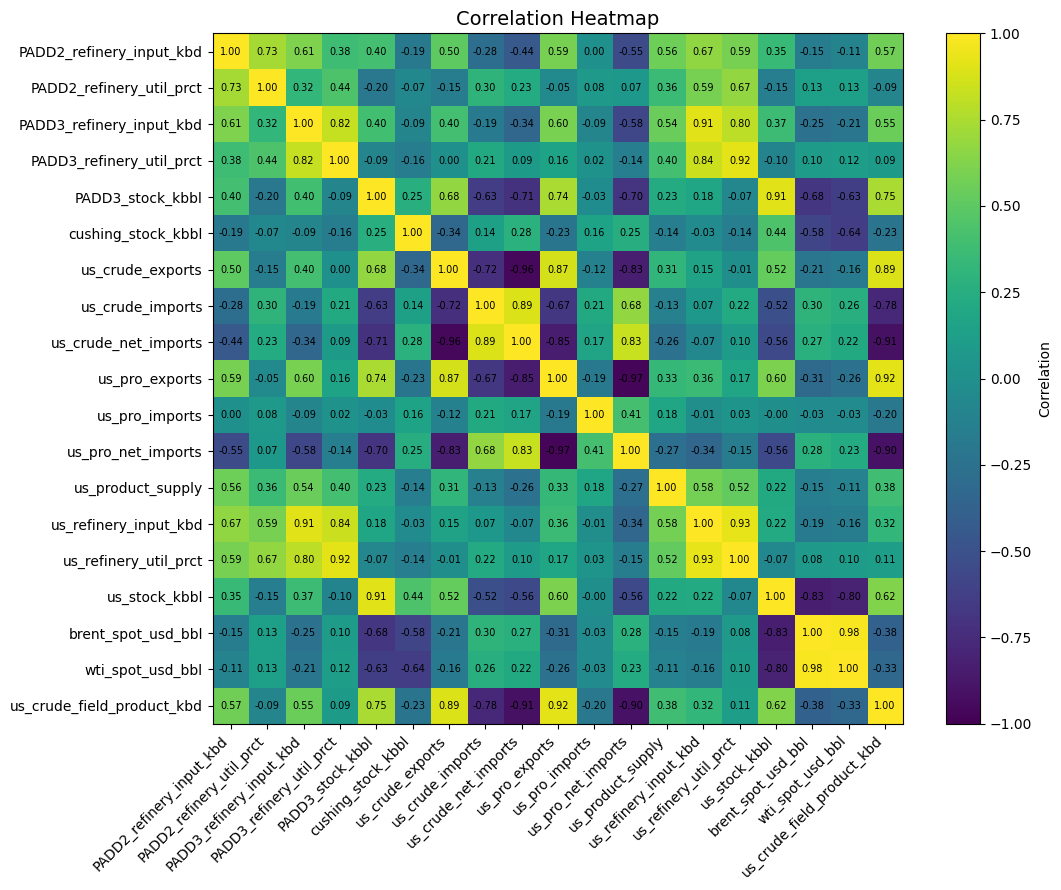

In [ ]:
corr = df.corr(numeric_only=True)

# Heatmap
fig, ax = plt.subplots(figsize=(12, 9))
im = ax.imshow(corr.values, vmin=-1, vmax=1)

# Ticks & labels
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation', rotation=90)

# Cells with values
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.values[i, j]:.2f}",
                ha='center', va='center', fontsize=7)

plt.title("Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

### Correlations & Relationships

Refinery input & utilization: Strong positive correlation (US: 0.93).

Stocks vs. prices: Strong negative correlation (Brent: –0.83, WTI: –0.80) — higher inventories tend to coincide with lower prices.

Crude exports & production: Very strong positive correlation (0.89).

Imports & exports: Strong negative relationship, reflecting trade balance shifts.

## Correlation Insights — WTI Spot Price

### Strong Positive Correlation

brent_spot_usd_bbl: 0.99 — Virtually perfect correlation with Brent prices, confirming they move almost identically in global markets.

us_crude_field_product_kbd: ~0.58 — Higher US crude production tends to coincide with higher WTI prices, though not perfectly (likely influenced by global supply-demand balance and geopolitical events).

### Moderate Positive Correlation

us_product_supply: ~0.38 — Suggests that higher domestic petroleum demand often aligns with higher WTI prices, possibly reflecting strong economic activity.

us_refinery_input_kbd: ~0.38 — Indicates that higher refinery runs correlate moderately with higher crude prices.

### Negative Correlation (Inventory Effect)

us_stock_kbbl: –0.38 — Larger US crude inventories are associated with lower WTI prices, consistent with supply-overhang pressure.

PADD3_stock_kbbl: ~–0.25 — Gulf Coast stock levels also have a negative price relationship, but weaker than total US stocks.

cushing_stock_kbbl: ~–0.26 — Higher Cushing stocks tend to depress WTI prices due to it being the delivery point for WTI contracts.

### Negative Correlation with Imports

us_crude_imports: ~–0.33 — Higher crude imports tend to coincide with weaker WTI prices.

us_crude_net_imports: ~–0.38 — Net import dependency negatively correlates with prices.



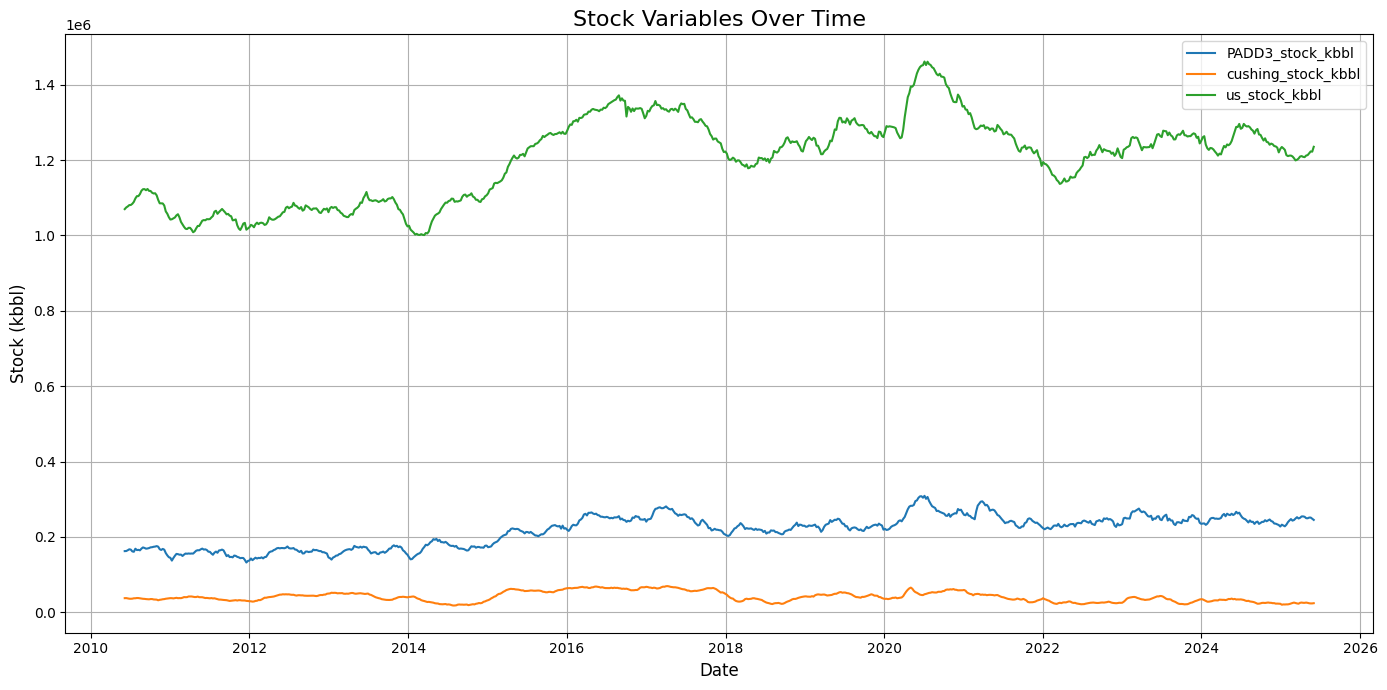

In [ ]:
# Stock Market Plot

# Stock-related columns
stock_cols = [col for col in df.columns if "stock" in col.lower()]

# Plot each stock variable
plt.figure(figsize=(14, 7))
for col in stock_cols:
    plt.plot(df.index, df[col], label=col)

plt.title("Stock Variables Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock (kbbl)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Stocks (Inventories)

US total crude stocks generally range 1.1–1.3 million kbbl, peaking near 1.46 million kbbl in 2020 during the COVID demand crash.

This peak is notable but not extreme enough to treat as a statistical outlier in the dataset.

Cushing stocks (price benchmark delivery point) are smaller (~20–70k kbbl) and exhibit relatively limited oscillations because the Cushing market is somewhat isolated from broader supply-demand dynamics due to limited crude oil exit capacity, making it less affected by external constraints.

PADD3 stocks trend similarly to total stocks, indicating Gulf Coast storage dominance.

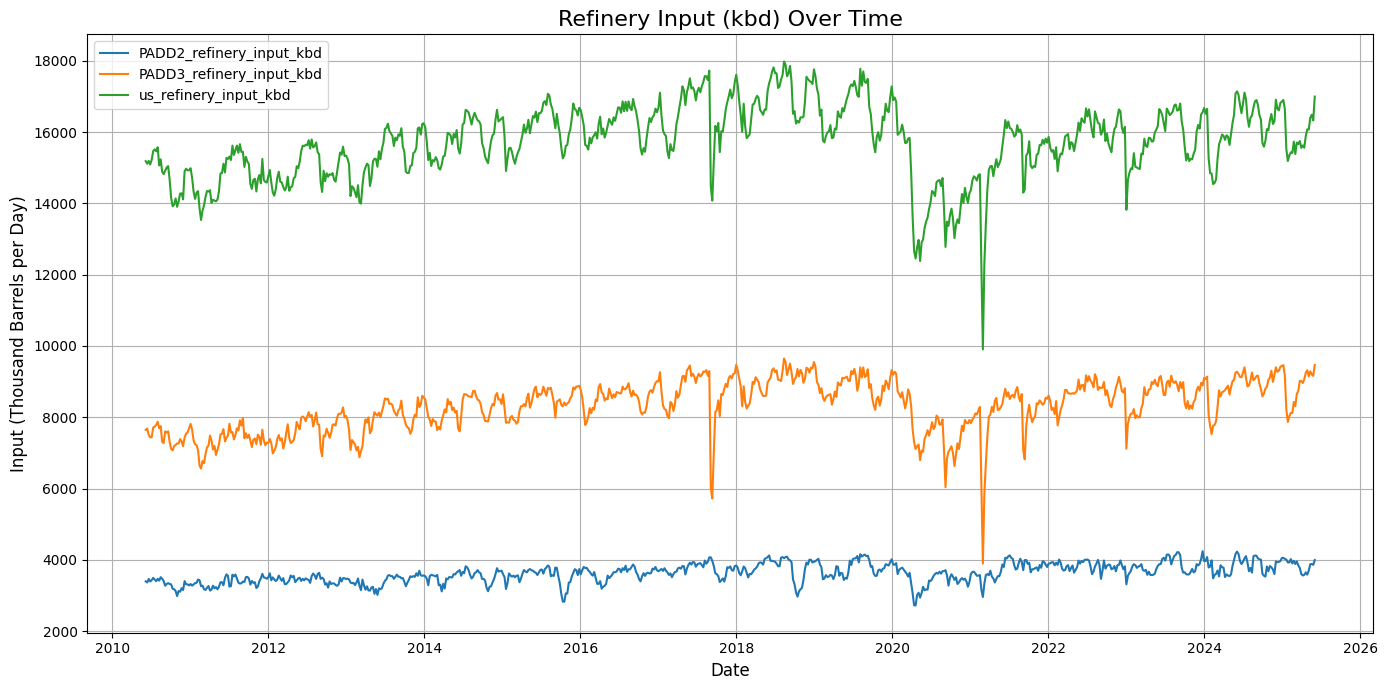

In [ ]:
# Refinery Input

input_cols = [col for col in df.columns if "input" in col.lower()]

# Plot each refinery input variable
plt.figure(figsize=(14, 7))
for col in input_cols:
    plt.plot(df.index, df[col], label=col)

plt.title("Refinery Input (kbd) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Input (Thousand Barrels per Day)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Refinery Input

US total refinery input fluctuates seasonally, peaking in summer.

PADD3 (Gulf Coast) processes ~2–3× more than PADD2 (Midwest).

Sharp dips correspond to major disruptions: early 2020 (COVID-19 demand collapse), occasional hurricane impacts, the February 2021 winter storm in Texas (utilization ~41%), and a smaller dip in 2017 linked to Hurricane Harvey, which temporarily shut down significant Gulf Coast refining capacity. All were followed by rapid recoveries.

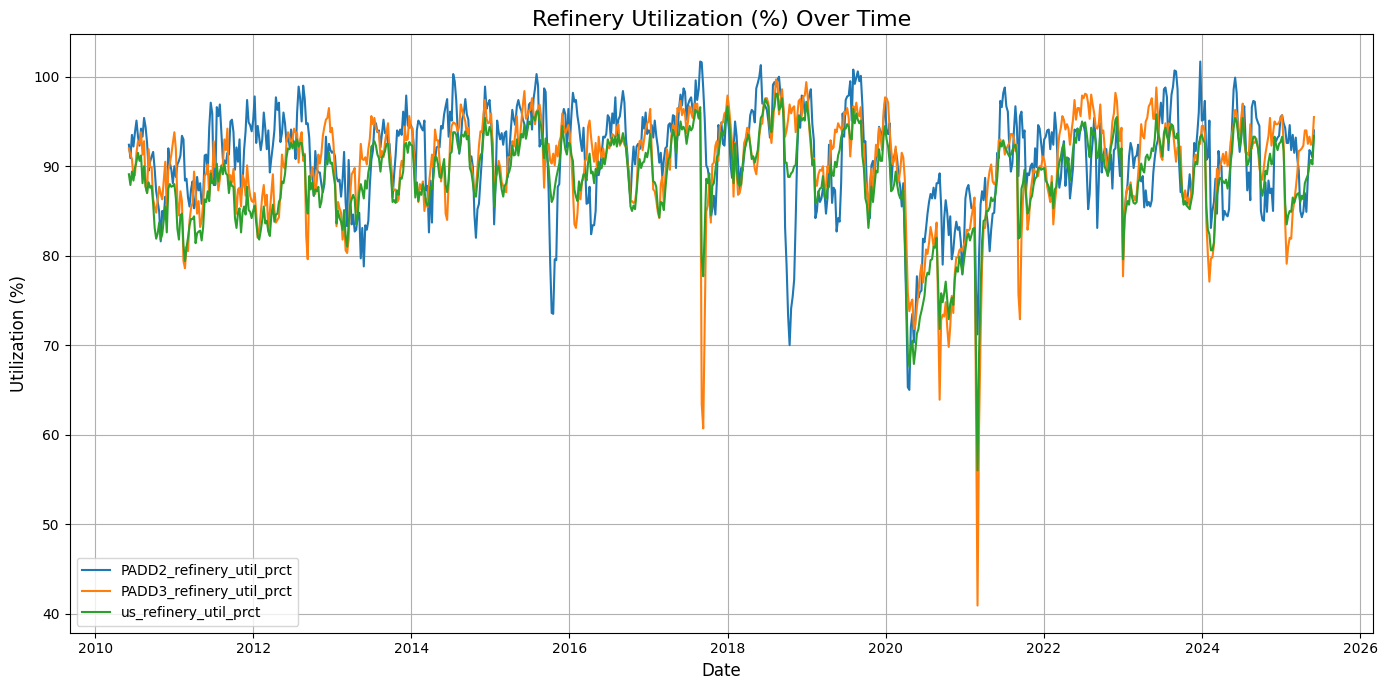

In [ ]:
# Percent of Refinery Utilization Plot

# Refinery utilization columns
util_cols = [col for col in df.columns if "util" in col.lower()]

# Plot each refinery utilization variable
plt.figure(figsize=(14, 7))
for col in util_cols:
    plt.plot(df.index, df[col], label=col)

plt.title("Refinery Utilization (%) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Utilization (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Utilization Rates

Typically 85–95%, with median around 91% (PADD2) and 90% (PADD3, US).

Outliers down to 40–60% during the major disruption already explained.

Boxplots confirm a tight core distribution with significant low-end outliers during crisis events.

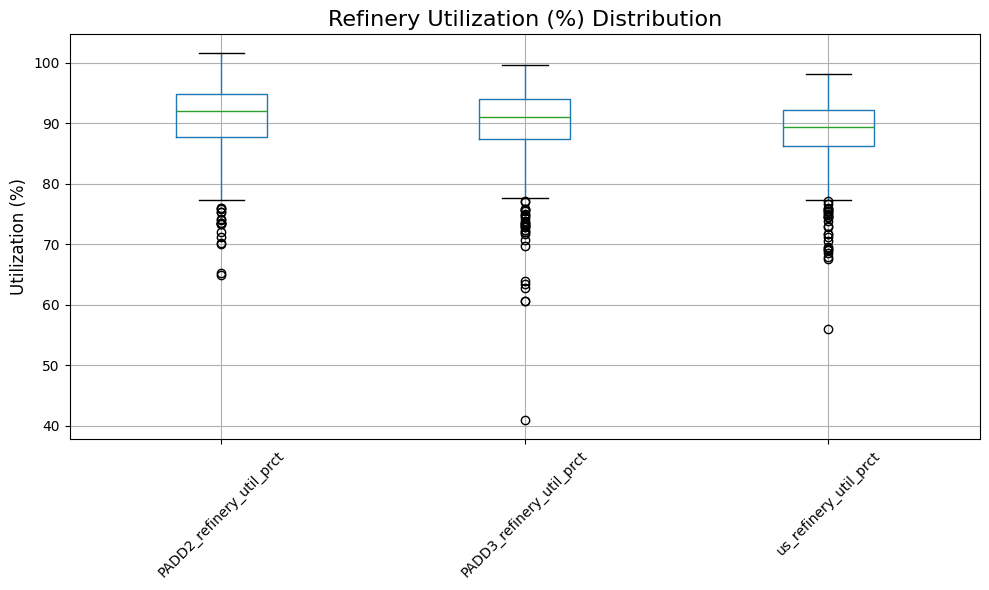

In [ ]:
# Box Plot for Refinery Utilization Columns
plt.figure(figsize=(10, 6))
df[util_cols].boxplot()
plt.title("Refinery Utilization (%) Distribution", fontsize=16)
plt.ylabel("Utilization (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

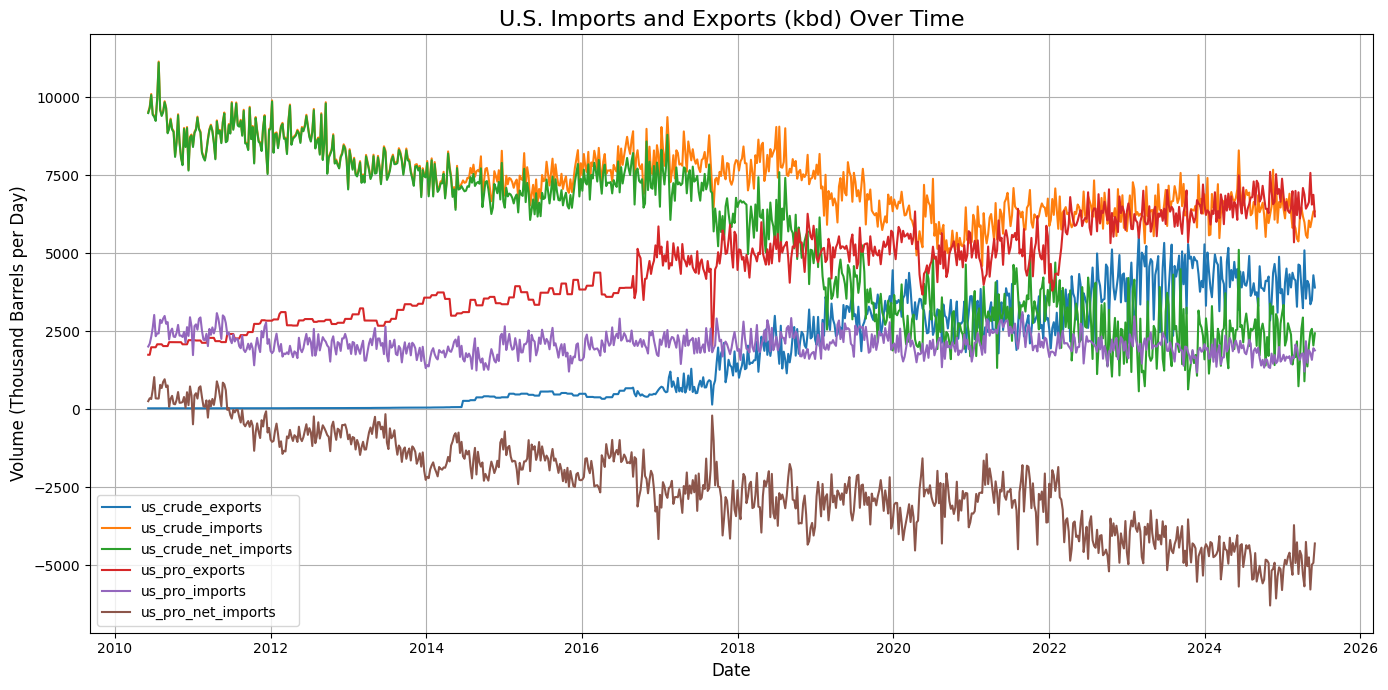

In [ ]:
# Crude oil Import and Export visualization

# Select import/export columns
trade_cols = [col for col in df.columns if "import" in col.lower() or "export" in col.lower()]

# Plot each import/export variable
plt.figure(figsize=(14, 7))
for col in trade_cols:
    plt.plot(df.index, df[col], label=col)

plt.title("U.S. Imports and Exports (kbd) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volume (Thousand Barrels per Day)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Imports & Exports

Crude imports steadily decline from ~9–10 Mbd in 2010 to ~6 Mbd by 2025.

Crude exports remained effectively at zero until late 2015 due to the US crude oil export ban, which was lifted in December 2015. After the ban removal, exports surged to ~4–5 Mbd.

Net crude imports shrink drastically, with the US nearing crude net export status by late 2019–2020.

Product exports (gasoline/diesel) grow steadily; imports remain stable/low, keeping net product imports negative (net exporter).

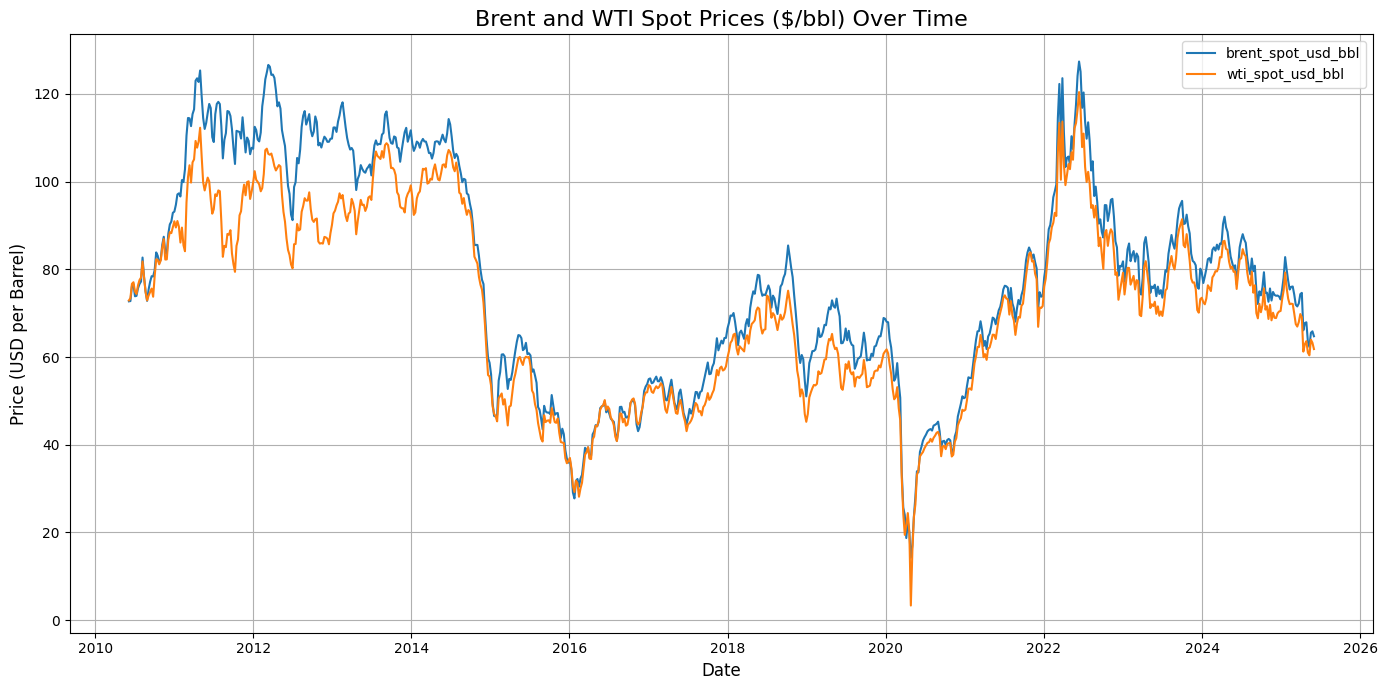

In [ ]:
# WTI and Brent prices

# Select price columns (case-insensitive)
price_cols = [col for col in df.columns if "usd_bbl" in col.lower()]

# Plot each price variable
plt.figure(figsize=(14, 7))
for col in price_cols:
    plt.plot(df.index, df[col], label=col)

plt.title("Brent and WTI Spot Prices ($/bbl) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD per Barrel)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


###  Prices (Brent & WTI)

Strong correlation (0.98) between Brent and WTI.

Median: Brent ~USD76/bbl, WTI ~$72/bbl.

Key events:

2011–2014 high price era (> $100/bbl).

2014–2016 oil price collapse (down to ~USD30/bbl).

Apr 2020 crash (WTI weekly average near USD0, with the daily settlement on April 20, 2020, for the May futures contract falling to - USD37.63/bbl — the first time in history prices went negative — due to a storage glut and the contract’s imminent expiry).

2022 price spike (> $120/bbl) after Russia–Ukraine conflict.

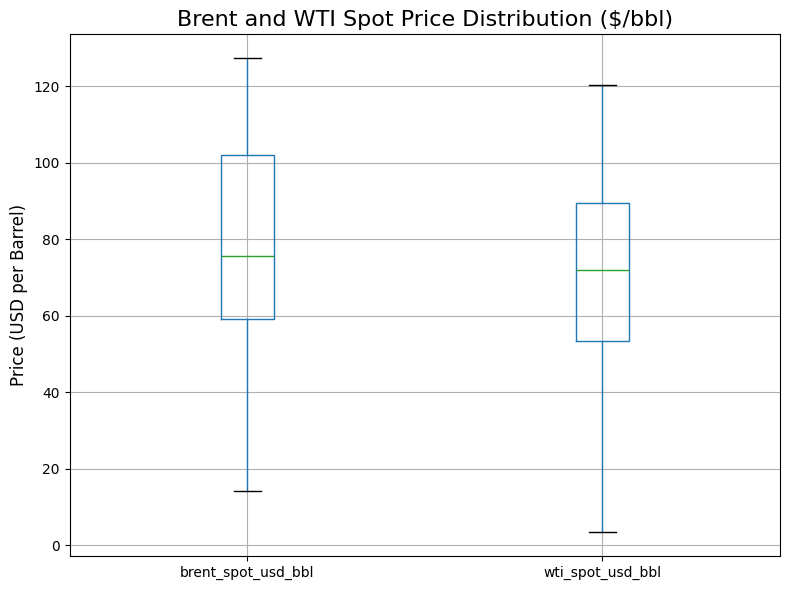

In [ ]:
# Box Plot
price_cols = ["brent_spot_usd_bbl", "wti_spot_usd_bbl"]

# Box plot for spot price distributions
plt.figure(figsize=(8, 6))
df[price_cols].boxplot()
plt.title("Brent and WTI Spot Price Distribution ($/bbl)", fontsize=16)
plt.ylabel("Price (USD per Barrel)", fontsize=12)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

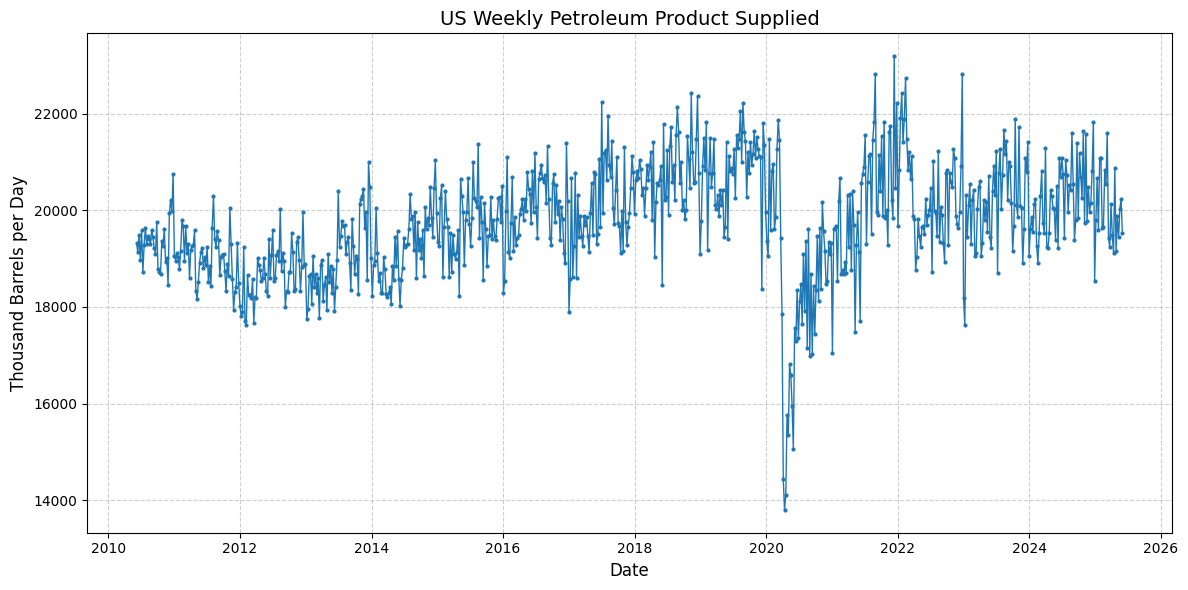

In [ ]:
# Product Supply

plt.figure(figsize=(12, 6))
plt.plot(weekly_all.index, weekly_all['us_product_supply'], marker='o', markersize=2, linestyle='-', linewidth=1)
plt.title('US Weekly Petroleum Product Supplied', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Thousand Barrels per Day', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Product Supply (Demand Proxy)

Ranges from 14 to 23 Mbd.

Gradual growth until early 2020, sharp COVID drop (~14 Mbd), then recovery.

Seasonal volatility: higher in summer driving seasons.

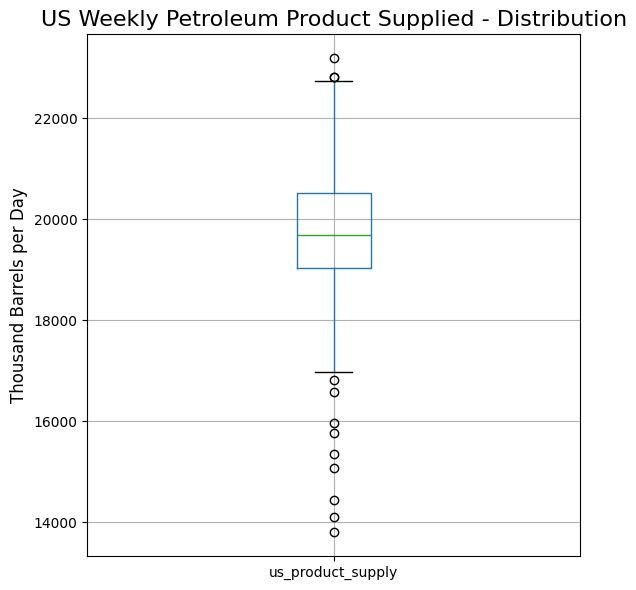

In [ ]:
# Box Plot

col = "us_product_supply"  # Replace with your actual column name

# Box plot
plt.figure(figsize=(6, 6))
df[[col]].boxplot()
plt.title("US Weekly Petroleum Product Supplied - Distribution", fontsize=16)
plt.ylabel("Thousand Barrels per Day", fontsize=12)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

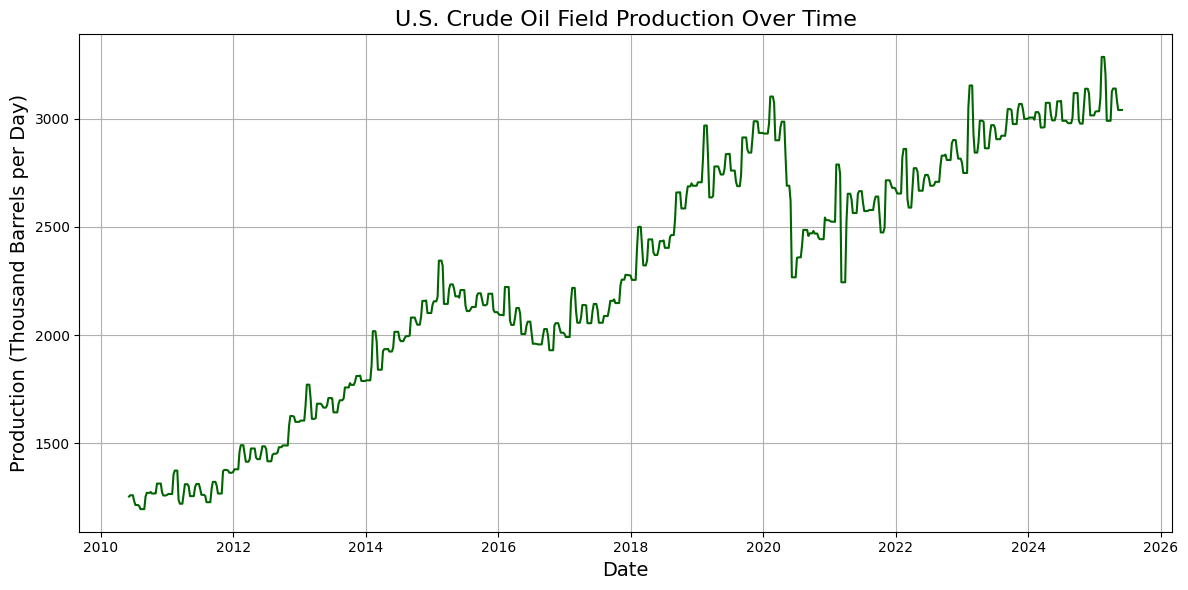

In [ ]:
# Plot U.S. crude field production

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['us_crude_field_product_kbd'], color='darkgreen', linewidth=1.5)
plt.title("U.S. Crude Oil Field Production Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Production (Thousand Barrels per Day)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Production

US crude field production rose from ~1.2 Mbd in 2010 to ~3.2 Mbd in 2025.

Growth driven by shale boom (2011–2019), dip in 2020, partial recovery thereafter.

### Key Takeaways

US refining runs and utilization are highly seasonal, resilient but vulnerable to major disruptions.

Stock levels are a leading indicator for price trends — 2020 storage build coincided with record-low prices.

Trade flows shifted fundamentally post-2015, with the US moving toward net crude exports and solidifying product export dominance.

Prices remain globally linked (Brent–WTI), with divergence mainly in short-term market dislocations.

Production growth from shale transformed US market position, reducing import dependency and increasing export capacity.

# Handling Outliers

After the basic statistic and plots, we can proceed to handle outliers when it is needed

## WTI & Brent Spot Prices

We know this April 2020 dip is not representative of real market fundamentals but a technical anomaly from the WTI May-2020 contract expiry and storage crisis due to COVID.

Replacing it with the average of the preceding and following weeks keeps the short-term trend intact while removing an extreme, non-repeatable shock that could distort statistical models.

In [ ]:
col = "wti_spot_usd_bbl"
outlier_date = "2020-04-19"  # week of April with the anomaly

# Replace with average of week before and week after
df.loc[outlier_date, col] = (df.loc["2020-04-12", col] + df.loc["2020-04-26", col]) / 2

### Justification

Market microstructure anomaly: The extreme price in April 2020 stems from the May-2020 WTI futures settlement on April 20, 2020, which fell to –$37.63/bbl because of a storage crunch and contract expiry mechanics. The weekly series shows this shock as an aberration relative to adjacent weeks.

Model stability: For time-series modeling of macro relationships (runs, stocks, flows), this single-point distortion can unduly influence coefficients and residual diagnostics. Replacing it with the local linear estimate (midpoint of adjacent weeks) preserves the underlying trend/seasonality while avoiding undue leverage.

Minimal bias, maximum transparency: Only one value is changed, with a full audit record (date, original, neighbors, replacement). Analyses that require the exact historical print (e.g., stress tests) should use the raw series; forecasting/causal modeling can use the cleaned one.

## Refinery Percent of Utilization and Input



In [ ]:
# Helper function to replace a single outlier with the average of the previous and next week
def fix_outlier(date_str, col):
    prev_val = df.iloc[df.index.get_loc(date_str) - 1][col]
    next_val = df.iloc[df.index.get_loc(date_str) + 1][col]
    df.loc[date_str, col] = (prev_val + next_val) / 2

# % UTILIZATION outliers --- Known short-lived disruptions:
# - 2017 Hurricane Harvey → US & PADD3
# - 2019 Winter storm → PADD2
# - 2021 Texas winter storm (single week) → US, PADD3, and PADD2

util_events = {
    "us_refinery_util_prct":    ["2017-09-10", "2021-02-28"],
    "PADD3_refinery_util_prct": ["2017-09-10", "2021-02-28"],
    "PADD2_refinery_util_prct": ["2019-02-10", "2021-02-28"],
}

for col, dates in util_events.items():
    for d in dates:
        fix_outlier(d, col)

# --- 2) REFINERY INPUT outliers ---
# Applying the same correction logic for consistency with utilization

input_events = util_events

for col, dates in input_events.items():
    for d in dates:
        fix_outlier(d, col)

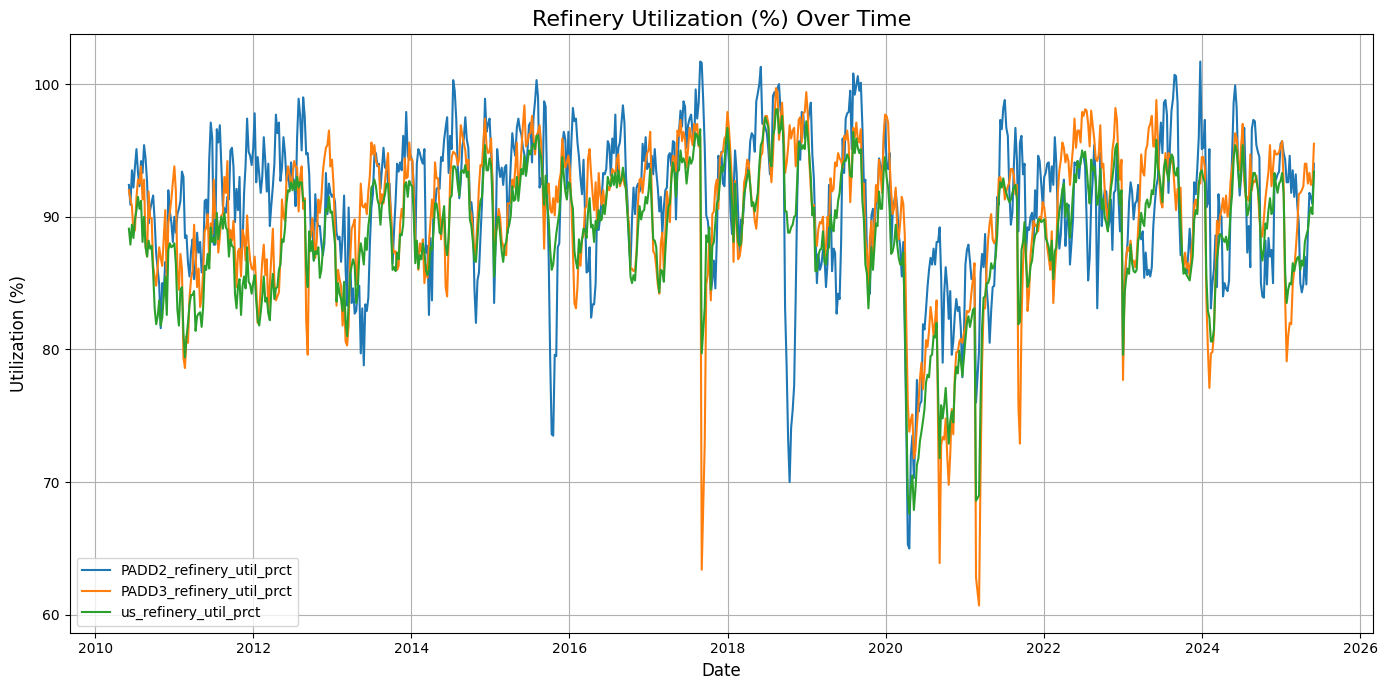

In [ ]:
# Percent of Refinery Utilization Plot

# Refinery utilization columns
util_cols = [col for col in df.columns if "util" in col.lower()]

# Plot each refinery utilization variable
plt.figure(figsize=(14, 7))
for col in util_cols:
    plt.plot(df.index, df[col], label=col)

plt.title("Refinery Utilization (%) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Utilization (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Outlier Treatment Summary**

We identified and corrected short-lived refinery utilization and input outliers caused by major disruptions in the U.S. oil industry. The corrections were applied only when the disruption was limited to a single week, so interpolation between the previous and next week provided a reasonable estimate without distorting longer-term patterns.

**Events and Corrections:**

1. Hurricane Harvey (August–September 2017)

   * Affected variables: `us_refinery_util_prct`, `PADD3_refinery_util_prct`, `us_refinery_input_kbd`, `PADD3_refinery_input_kbd`
   * Week corrected: 2017-09-10
   * Rationale: Hurricane Harvey caused an abrupt single-week drop in utilization and input, followed by quick recovery. Values were replaced with the average of the week before and the week after.

2. PADD2 Winter Storm (February 2019)

   * Affected variables: `PADD2_refinery_util_prct`, `PADD2_refinery_input_kbd`
   * Week corrected: 2019-02-10
   * Rationale: Localized severe weather event caused a sharp but short-lived drop.

3. Texas Freeze (February 2021)

   * Affected variables: `us_refinery_util_prct`, `PADD3_refinery_util_prct`, `PADD2_refinery_util_prct`,
     `us_refinery_input_kbd`, `PADD3_refinery_input_kbd`, `PADD2_refinery_input_kbd`
   * Week corrected: 2021-02-28
   * Rationale: Severe winter storm disrupted operations in Texas and surrounding areas for a single week.


**Why We Did Not Correct Certain Variables:**

`us_product_supply`: Outliers were not treated because drops typically lasted 3–4 weeks, making simple week-to-week interpolation inappropriate. These represent sustained operational or demand changes rather than data anomalies.

Other series (e.g., `cushing_stock_kbbl`, crude exports/imports):
  No corrections applied as detected fluctuations aligned with broader market events or persistent shifts, not isolated measurement or operational anomalies.


Justification for Method Interpolation between the previous and next week is valid when the outlier is caused by a short, singular disruption and the surrounding values are stable. Avoided applying the method to multi-week events, where interpolation would artificially smooth real sustained changes.


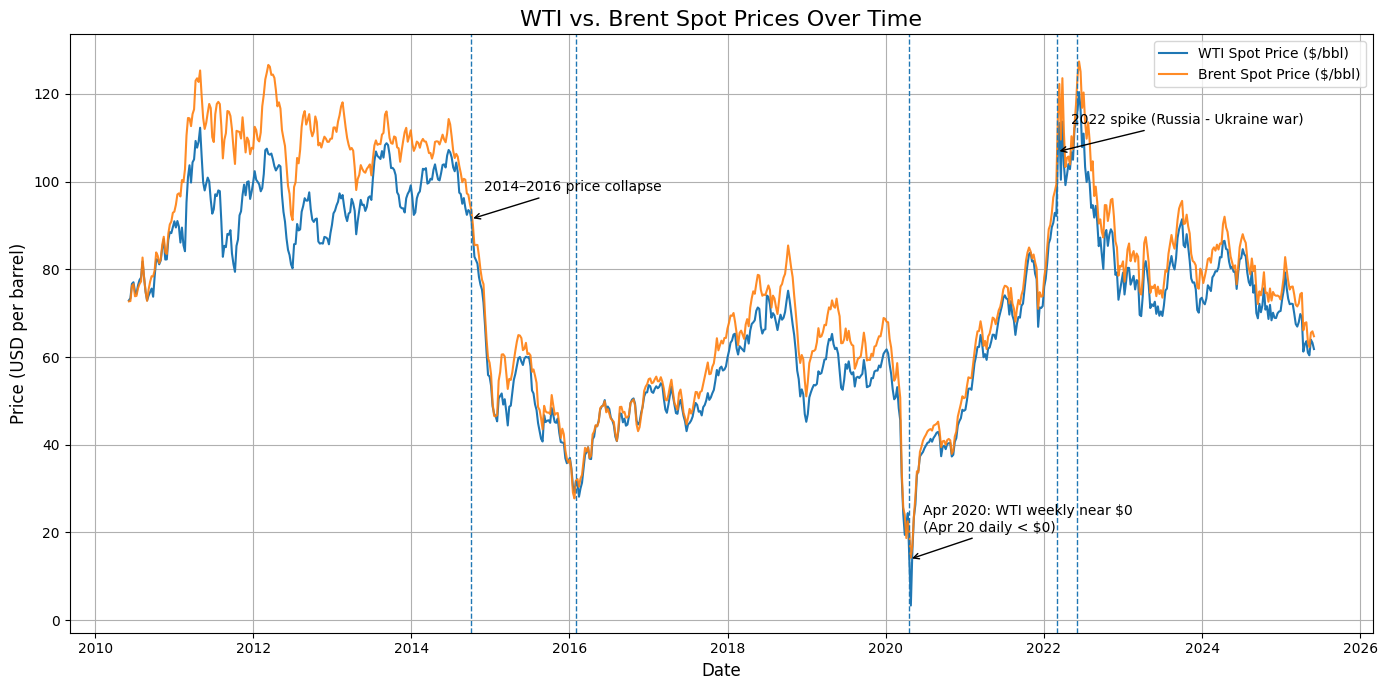

In [ ]:
# Plot WTI vs Brent with annotations
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df.index, df['wti_spot_usd_bbl'], label='WTI Spot Price ($/bbl)')
ax.plot(df.index, df['brent_spot_usd_bbl'], label='Brent Spot Price ($/bbl)', alpha=0.9)

# Key event markers (no explicit colors)
events = [
    ("2014-10-01", "2016-02-01", "2014–2016 price collapse"),
    ("2020-04-19", "2020-04-19", "Apr 2020: WTI weekly near $0\n(Apr 20 daily < $0)"),
    ("2022-03-01", "2022-06-01", "2022 spike (Russia - Ukraine war)")
]

for start, end, label in events:
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)
    # vertical lines at start/end (defaults to matplotlib colors)
    ax.axvline(start_dt, linestyle='--', linewidth=1)
    if end_dt != start_dt:
        ax.axvline(end_dt, linestyle='--', linewidth=1)
    # annotation near start
    ax.annotate(label, xy=(start_dt, df.loc[start_dt:, 'wti_spot_usd_bbl'].iloc[0]),
                xytext=(10, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', linewidth=1))

ax.set_title("WTI vs. Brent Spot Prices Over Time", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Price (USD per barrel)", fontsize=12)
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

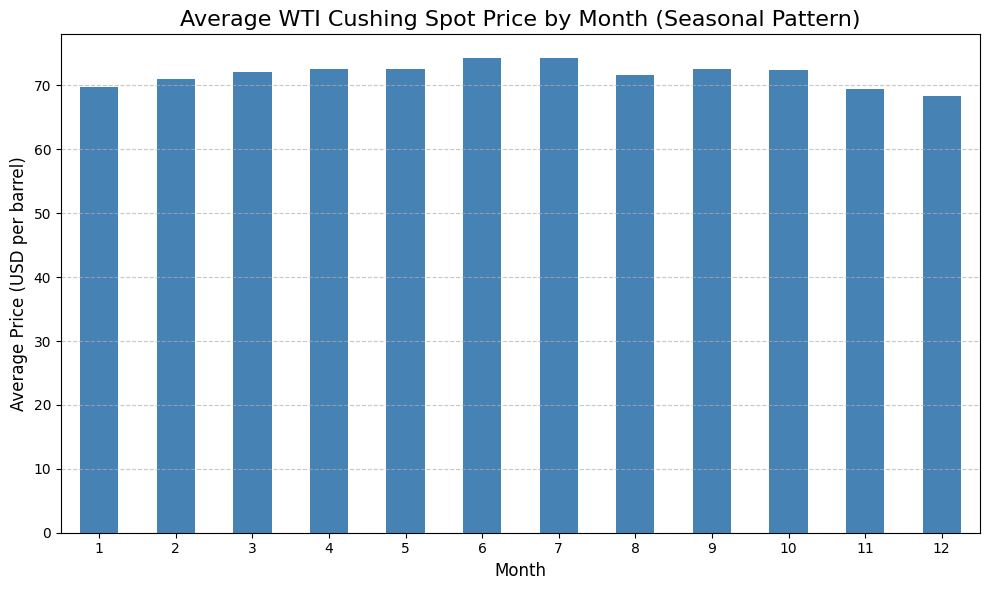

In [ ]:
# Seasonal Pattern Analysis

# Extract month from index
df['month'] = df.index.month

# Group by month and calculate average WTI price
monthly_avg_wti = df.groupby('month')['wti_spot_usd_bbl'].mean()

# Plot seasonal pattern
plt.figure(figsize=(10, 6))
monthly_avg_wti.plot(kind='bar', color='steelblue')

plt.title("Average WTI Cushing Spot Price by Month (Seasonal Pattern)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Price (USD per barrel)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


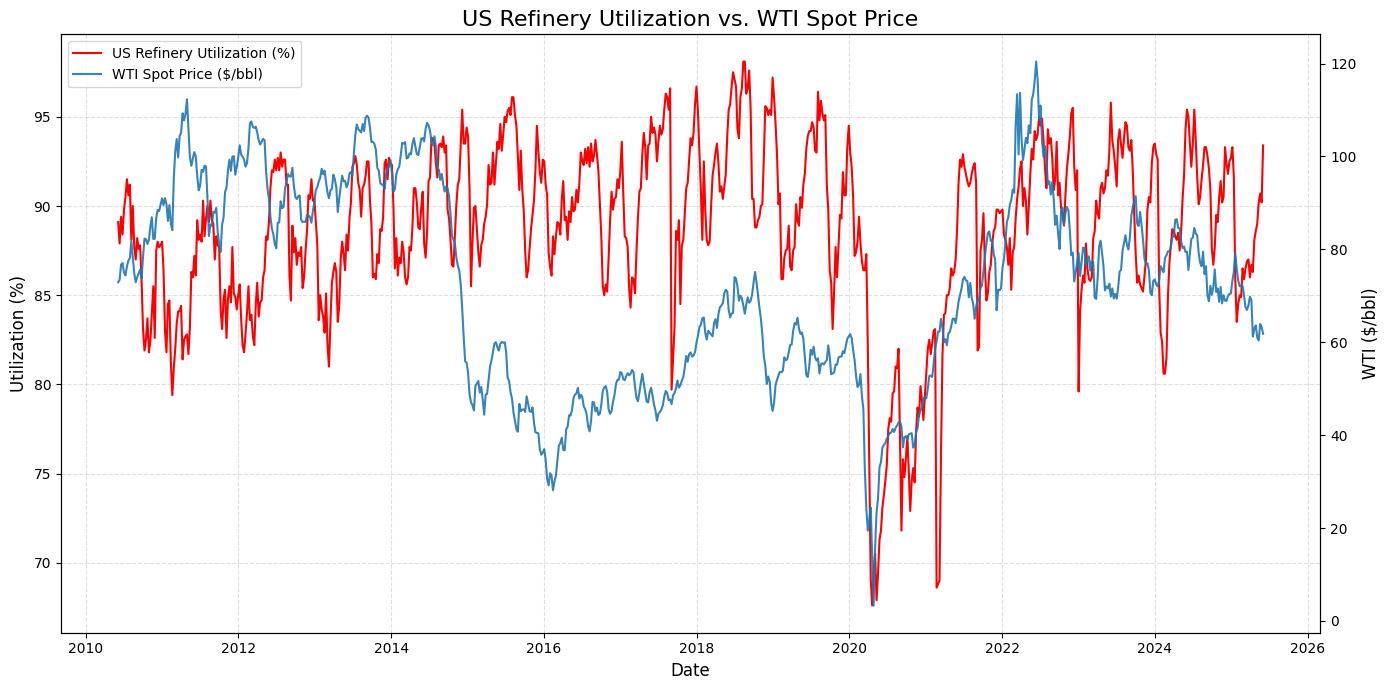

In [ ]:
# Refinery Utilization vs. WTI Prices — Demand Signal Analysis

# Columns used
util_col = "us_refinery_util_prct"
wti_col  = "wti_spot_usd_bbl"

fig, ax1 = plt.subplots(figsize=(14, 7))

# Left y-axis: Utilization (%)
ax1.plot(df.index, df[util_col], label="US Refinery Utilization (%)", color='red')
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Utilization (%)", fontsize=12)
ax1.grid(True, which="both", axis="both", linestyle="--", alpha=0.4)

# Right y-axis: WTI ($/bbl)
ax2 = ax1.twinx()
ax2.plot(df.index, df[wti_col], label="WTI Spot Price ($/bbl)", alpha=0.9)
ax2.set_ylabel("WTI ($/bbl)", fontsize=12)

# Combined legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("US Refinery Utilization vs. WTI Spot Price", fontsize=16)
plt.tight_layout()
plt.show()

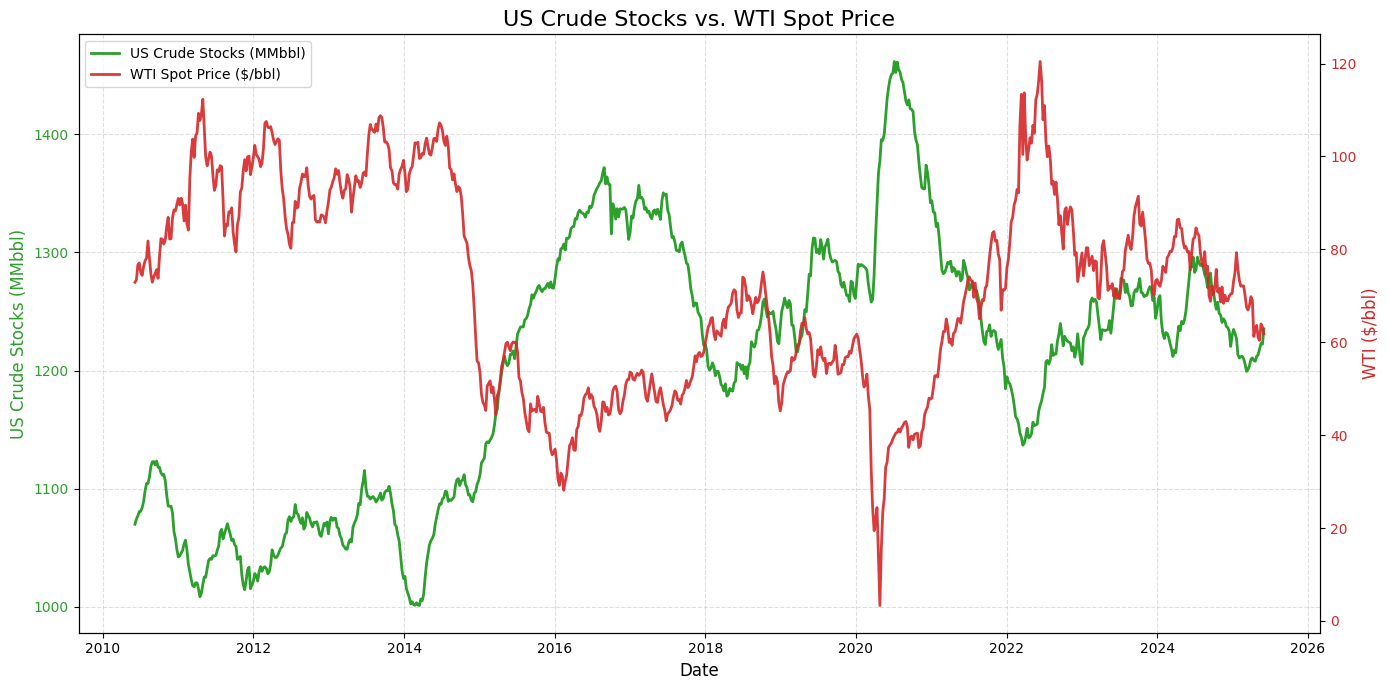

In [ ]:
# Crude Stocks vs. WTI Spot Price

stocks_col = "us_stock_kbbl"      # kbbl
wti_col    = "wti_spot_usd_bbl"   # $/bbl

# Scale stocks to million barrels (MMbbl)
stocks_mmbbl = df[stocks_col] / 1_000.0

fig, ax1 = plt.subplots(figsize=(14, 7))

# Left axis: Stocks (MMbbl)
c1 = "tab:green"
ax1.plot(df.index, stocks_mmbbl, color=c1, linewidth=2, label="US Crude Stocks (MMbbl)")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("US Crude Stocks (MMbbl)", color=c1, fontsize=12)
ax1.tick_params(axis="y", labelcolor=c1)
ax1.grid(True, linestyle="--", alpha=0.4)

# Right axis: WTI ($/bbl)
ax2 = ax1.twinx()
c2 = "tab:red"
ax2.plot(df.index, df[wti_col], color=c2, linewidth=2, alpha=0.9, label="WTI Spot Price ($/bbl)")
ax2.set_ylabel("WTI ($/bbl)", color=c2, fontsize=12)
ax2.tick_params(axis="y", labelcolor=c2)

# Combined legend
lines, labels = [], []
for ax in (ax1, ax2):
    lns, lbls = ax.get_legend_handles_labels()
    lines += lns; labels += lbls
ax1.legend(lines, labels, loc="upper left")

plt.title("US Crude Stocks vs. WTI Spot Price", fontsize=16)
plt.tight_layout()
plt.show()

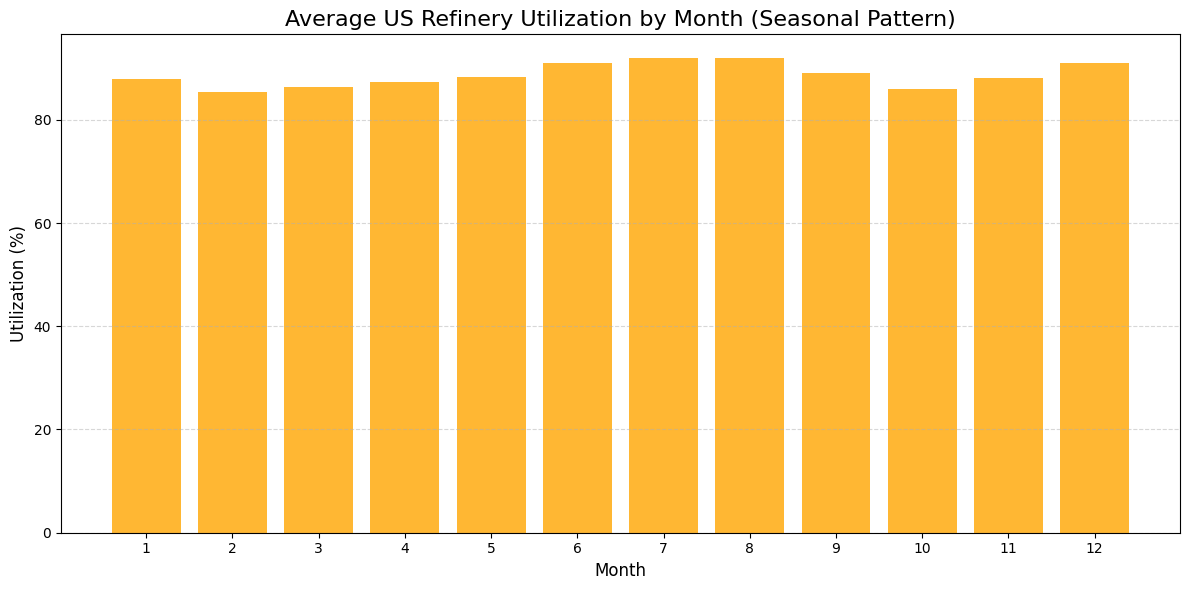

In [ ]:
# Seasonal Pattern of US Refinery Utilization.

util_col = "us_refinery_util_prct"

# Extract month and group
monthly_util = df.groupby(df.index.month)[util_col].mean()

plt.figure(figsize=(12, 6))
plt.bar(monthly_util.index, monthly_util.values, color="orange", alpha=0.8)

plt.title("Average US Refinery Utilization by Month (Seasonal Pattern)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Utilization (%)", fontsize=12)
plt.xticks(range(1, 13))
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

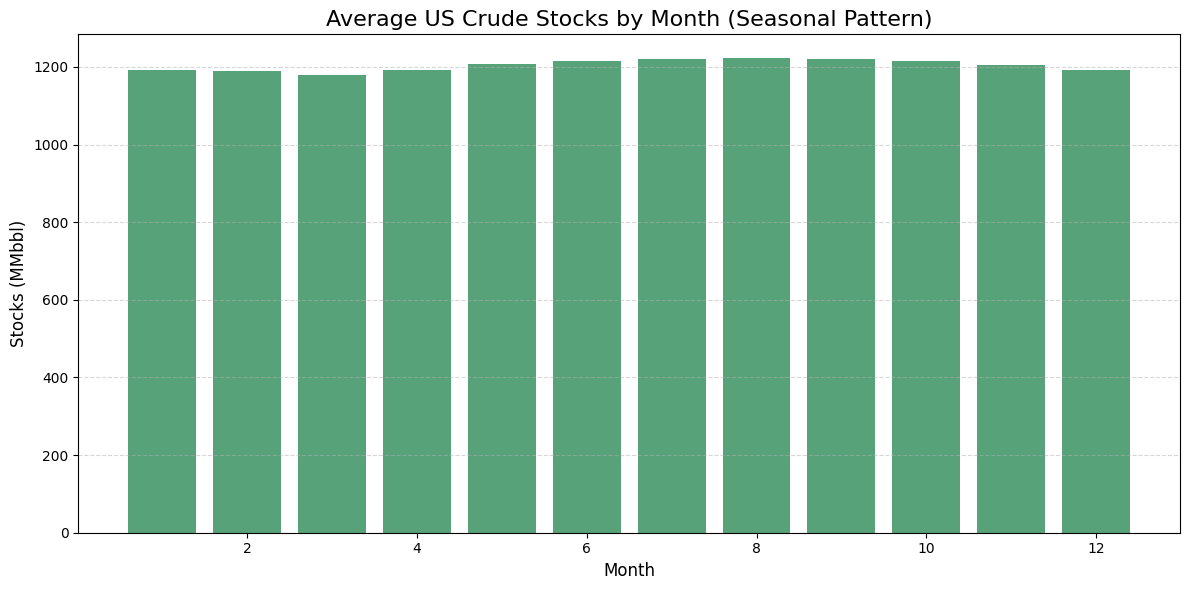

In [ ]:
# Seasonal pattern of US Crude Stocks by month
stock_col = "us_stock_kbbl"  # adjust if different name
monthly_avg_stocks = df[stock_col].groupby(df.index.month).mean()

plt.figure(figsize=(12, 6))
plt.bar(monthly_avg_stocks.index, monthly_avg_stocks.values / 1_000, color="seagreen", alpha=0.8)
plt.title("Average US Crude Stocks by Month (Seasonal Pattern)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Stocks (MMbbl)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()